In [1]:
import pyspark
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml import Transformer, Estimator, Pipeline
from pyspark.ml.classification import LogisticRegression
from mmlspark import *
from mmlspark import toNDArray

import numpy as np, pandas as pd, os, sys, time
from PIL import Image
from os.path import join, abspath, exists, basename
import zipfile
import cv2

DATA_DIR = './data'

### Download images

In [2]:
!wget 'https://isvdemostorageaccount.blob.core.windows.net/wood-knots/labelled_knot_images_png.zip'
!wget 'http://www.ee.oulu.fi/research/imag/knots/KNOTS/names.txt'

if os.path.exists(DATA_DIR):
    !rm -r data
    
!mkdir $DATA_DIR
!mv *.zip $DATA_DIR
!mv names.txt $DATA_DIR

# unzip directories
!cd $DATA_DIR
zip_ref = zipfile.ZipFile(os.path.join(DATA_DIR, 'labelled_knot_images_png.zip'), 'r')
zip_ref.extractall(DATA_DIR)

zip_ref.close()

# remove zip files
os.remove(os.path.join(DATA_DIR, 'labelled_knot_images_png.zip'))


--2018-08-20 21:50:20--  https://isvdemostorageaccount.blob.core.windows.net/wood-knots/labelled_knot_images_png.zip
Resolving isvdemostorageaccount.blob.core.windows.net (isvdemostorageaccount.blob.core.windows.net)... 13.88.144.240
Connecting to isvdemostorageaccount.blob.core.windows.net (isvdemostorageaccount.blob.core.windows.net)|13.88.144.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5672485 (5.4M) [application/x-zip-compressed]
Saving to: ‘labelled_knot_images_png.zip’

labelled_knot_image 100%[===================>]   5.41M  --.-KB/s    in 0.07s   

2018-08-20 21:50:20 (73.5 MB/s) - ‘labelled_knot_images_png.zip’ saved [5672485/5672485]

--2018-08-20 21:50:20--  http://www.ee.oulu.fi/research/imag/knots/KNOTS/names.txt
Resolving www.ee.oulu.fi (www.ee.oulu.fi)... 130.231.61.28, 2001:708:520:80::28
Connecting to www.ee.oulu.fi (www.ee.oulu.fi)|130.231.61.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11189 (11K) [text/

## Featurize images

### Download a pre-trained model and define input and output

In [3]:
model = ModelDownloader(spark, "./models").downloadByName("ResNet50")

resnet = ImageFeaturizer()\
    .setInputCol("image")\
    .setOutputCol("features")\
    .setModelLocation(spark, model.uri)\
    .setLayerNames(model.layerNames)\
    .setCutOutputLayers(1)

get_image_path = udf(lambda z: str.split(z.path, ':')[1] , StringType())

In [4]:
imageDir = os.path.join(DATA_DIR, 'knot_images_png')
labelled_images = spark.readImages(imageDir, recursive = True, sampleRatio = 1)
labelled_images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- type: integer (nullable = true)
 |    |-- bytes: binary (nullable = true)



image type: <class 'pyspark.sql.types.Row'>, number of fields: 5
image path: file:/home/remoteuser/notebooks/active-learning-workshop/image_featurization/data/knot_images_png/knot0253.png
height: 280, width: 162, OpenCV type: 16


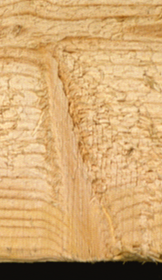

In [5]:
data = labelled_images.take(3)
im = data[2][0]

print("image type: {}, number of fields: {}".format(type(im), len(im)))
print("image path: {}".format(im.path))
print("height: {}, width: {}, OpenCV type: {}".format(im.height, im.width, im.type))

arr = toNDArray(im)     # convert to numpy array
Image.fromarray(arr, "RGB")   # display the image inside notebook

In [6]:
labeled_featurized = resnet.transform(labelled_images)
labeled_featurized.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- type: integer (nullable = true)
 |    |-- bytes: binary (nullable = true)
 |-- features: vector (nullable = true)



### How it works

![Resnet 18](https://i.imgur.com/Mb4Dyou.png)

In [7]:
labeled_featurized_with_path = labeled_featurized.withColumn('path', get_image_path('image')).drop('image')
labeled_featurized_with_path.printSchema()

root
 |-- features: vector (nullable = true)
 |-- path: string (nullable = true)



In [8]:
del labeled_featurized, labelled_images

## Join features and labels

In [9]:
# Import labeled images
labeled_images_list = os.listdir(os.path.join(DATA_DIR, 'knot_images_png'))
image_list = [os.path.abspath(os.path.join(DATA_DIR, 'knot_images_png', l)) for l in labeled_images_list]
base_img_name = [str.split(basename(img_path), '.')[0] for img_path in image_list]
image_df = pd.DataFrame({'img_name': base_img_name, 'path': image_list})

# Process labels
names_df = pd.read_csv(os.path.join(DATA_DIR, 'names.txt'), sep = " ", names=['img_name', 'label', 'nan'], header=None).drop('nan', 1)
base_name = [str.split(img, '.')[0] for img in names_df.img_name]
names_df.img_name = base_name

# Merge images and labels
merged_df = pd.merge(image_df, names_df, on=['img_name']).drop('img_name', 1)

# All knot classes
KNOT_CLASSES = ["sound_knot", "dry_knot", "encased_knot"]
merged_df = merged_df[merged_df.label.isin(KNOT_CLASSES)]

labels_df = spark.createDataFrame(merged_df)
labels_df.printSchema()

del image_df, names_df, merged_df

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)



In [10]:
labeled_features = labeled_featurized_with_path.join(labels_df, "path", how='right')

In [11]:
labeled_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)



### Save features to file

In [12]:
features_arr = labeled_features.collect()


In [13]:
def to_csv_lines(data):
    s = ','.join([str(f) for f in data.features])
    s = ','.join((data.path, data.label, s))
    return(s)

data_to_file = [to_csv_lines(record) for record in features_arr]

In [14]:
feature_csv = os.path.join(DATA_DIR, 'labelled_knots_featurized_resnet50.csv')
with open(feature_csv, 'w') as fp:
    fp.write('\n'.join(data_to_file))

In [15]:
del features_arr